In [21]:
from os.path import join 
from obspy.geodetics import kilometer2degrees
from obspy.taup import TauPyModel
import numpy as np
import Create_Vmod
import re
import matplotlib.pyplot as plt
from SS_MTI import Gradient,PhaseTracer,PreProcess

# Save directory

In [9]:
save_path= (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Source_Receiver/Full_wave_rec/"
)

# Source parameters:

In [10]:
src_depth = 20.0
epi_in_km = 1774.7380
epi = kilometer2degrees(epi_in_km, radius=3389.5)
baz = 0.0

dt = 0.025

bm_start_model = "/home/nienke/Documents/Research/Data/MTI/MT_vs_STR/bm_models/TAYAK_BKE.bm"
m_rr = 0.0
m_tt = 1.0
m_pp = 0.0
m_rt = 0.0
m_rp = 0.0
m_tp = 0.0
focal_mech = [m_rr, m_tt, m_pp, m_rt, m_rp, m_tp]


## Create the .dat file and .tvel files

In [136]:
# Create_Vmod.create_dat_file(
#     src_depth, epi_in_km, baz, focal_mech, dt, save_path, bm_start_model,
# )
with open(join(save_path, "crfl.dat"), "r+") as f:
    data = f.readlines()
""" automatically create .tvel file """
depth = np.zeros(len(data[3:-18]))
vp = np.zeros(len(data[3:-18]))
vs = np.zeros(len(data[3:-18]))
dens = np.zeros(len(data[3:-18]))
for i, line in enumerate(data[3:-18]):
    """ search for and create floats from the string line """
    flt = np.array(re.findall("\d+\.\d+", line), dtype=float)
    depth[i] = flt[0]
    vp[i] = flt[1]
    vs[i] = flt[3]
    dens[i] = flt[5]
Taup_mod_name = "BKE_mod"
Create_Vmod.create_tvel_file(depth, vp, vs, dens, save_path, Taup_mod_name)
taup_file_path = join(save_path,Taup_mod_name + ".tvel")
taup_file_path = Gradient.create_taup_model(taup_file_path,save_path)

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Source_Receiver/Full_wave_rec/BKE_mod.tvel' ...


# Arrivals

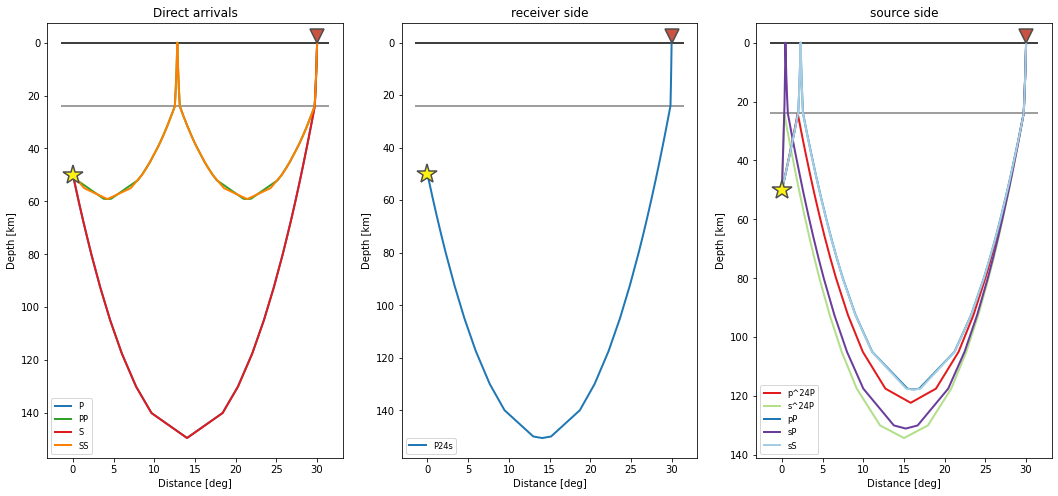

In [147]:
model = TauPyModel(taup_file_path)
src_depth = 50.

direct_phases = ["P", "S","SS","PP"]
tt_direct = model.get_travel_times(
            source_depth_in_km=src_depth, distance_in_degree=epi, phase_list=direct_phases
        )
arrivals = model.get_ray_paths(source_depth_in_km=src_depth,
                                 distance_in_degree=epi,
                                 phase_list=direct_phases)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
arrivals.plot_rays(phase_list=direct_phases, plot_type="cartesian",show = False, legend = True , ax=ax[0])
ax[0].invert_yaxis()
x = ax[0].get_xlim()
y = ax[0].get_ylim()
# ax[0].hlines(10., x[0], x[1], color="0.5", zorder=-1)
ax[0].hlines(24., x[0], x[1], color="0.5", zorder=-1)
ax[0].hlines(0., x[0], x[1], color="black", zorder=-1)
ax[0].set_title("Direct arrivals")

rec_phases = ["P24s","S24p"]
tt_rec = model.get_travel_times(
            source_depth_in_km=src_depth, distance_in_degree=epi, phase_list=rec_phases
        )
arrivals = model.get_ray_paths(source_depth_in_km=src_depth,
                                 distance_in_degree=epi,
                                 phase_list=rec_phases)
arrivals.plot_rays(phase_list=rec_phases, plot_type="cartesian",show = False, legend = True , ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title("receiver side")
x = ax[1].get_xlim()
y = ax[1].get_ylim()
# ax[1].hlines(10., x[0], x[1], color="0.5", zorder=-1)
ax[1].hlines(24., x[0], x[1], color="0.5", zorder=-1)
ax[1].hlines(0., x[0], x[1], color="black", zorder=-1)

src_phases = ["pP","sS","pS","sP","s^24P","p^24P", "p^24S"]
tt_src = model.get_travel_times(
            source_depth_in_km=src_depth, distance_in_degree=epi, phase_list=src_phases
        )
arrivals = model.get_ray_paths(source_depth_in_km=src_depth,
                                 distance_in_degree=epi,
                                 phase_list=src_phases)
arrivals.plot_rays(phase_list=src_phases, plot_type="cartesian",show = False, legend = True , ax=ax[2])
ax[2].invert_yaxis()
ax[2].set_title("source side")
x = ax[2].get_xlim()
y = ax[2].get_ylim()
# ax[1].hlines(10., x[0], x[1], color="0.5", zorder=-1)
ax[2].hlines(24., x[0], x[1], color="0.5", zorder=-1)
ax[2].hlines(0., x[0], x[1], color="black", zorder=-1)

# Plot

(-1e-09, 1e-09)

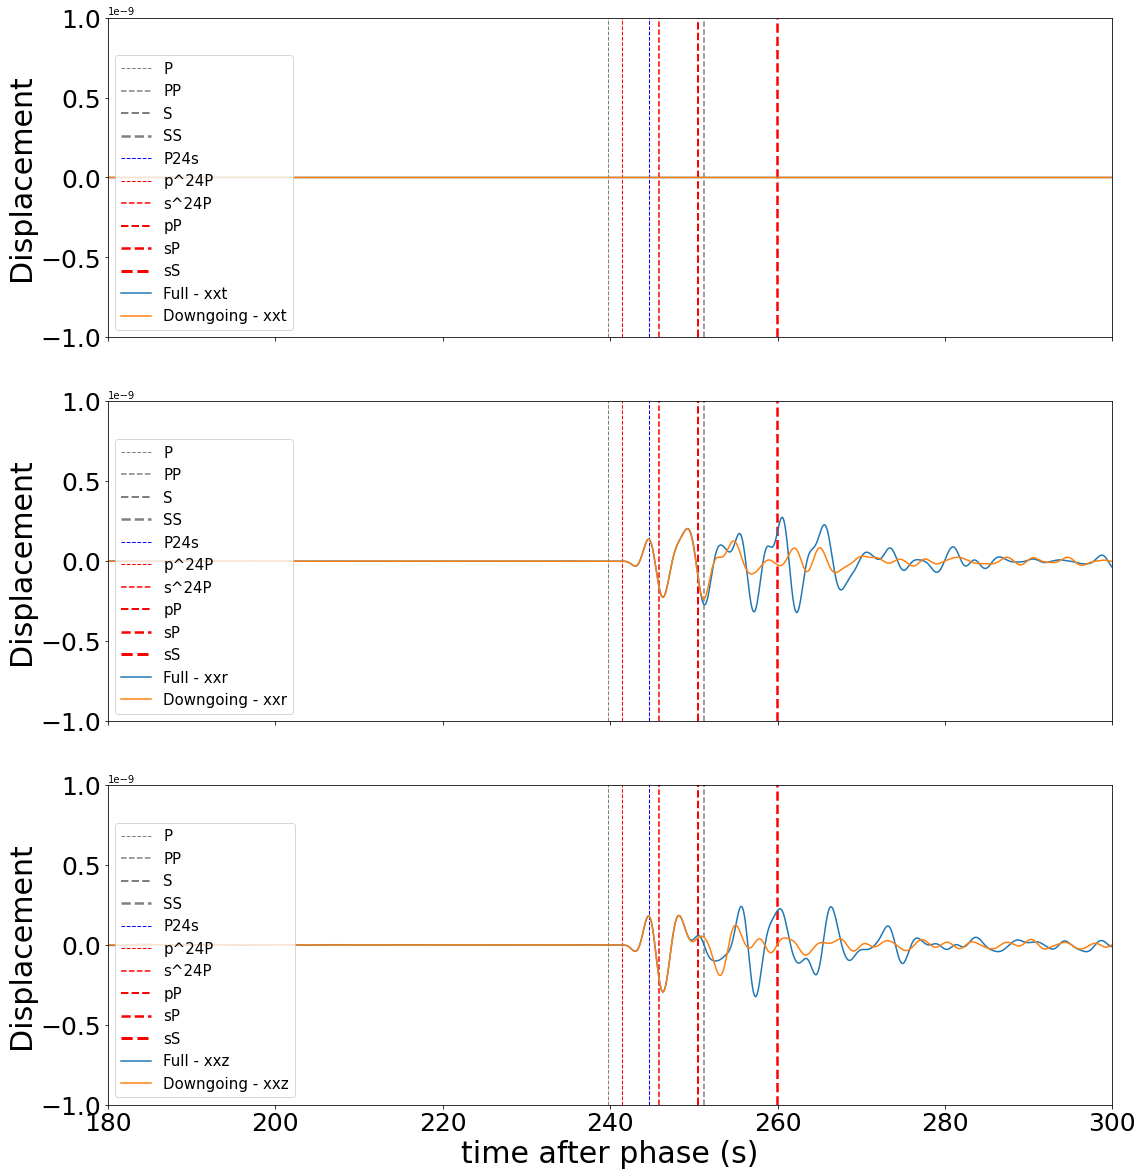

In [159]:
st_full = Gradient.read_refl_mseeds(path=save_path)
st_down = Gradient.read_refl_mseeds(
    path="/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Source_Receiver/Downgoing_rec/"
)
filt_tr = True
fmin = 0.1
fmax = 0.4

fig, ax = plt.subplots(nrows=len(st_full), ncols=1, sharex="all",sharey="all", figsize=(18, 20))
for i, (tr_full,tr_down) in enumerate(zip(st_full.copy(),st_down.copy())):
    if filt_tr:
        PreProcess.filter_tr(tr_full, fmin=fmin, fmax=fmax, zerophase=False)
        PreProcess.filter_tr(tr_down, fmin=fmin, fmax=fmax, zerophase=False)
    for j,tt_d in enumerate(tt_direct):
        ax[i].axvline(x=tt_d.time, c="grey", ls="dashed",lw = 0.5*j+1,label = tt_d.name)    
    for j,tt_r in enumerate(tt_rec):
        ax[i].axvline(x=tt_r.time, c="blue", ls="dashed",lw = 0.5*j+1,label = tt_r.name)
    for j,tt_s in enumerate(tt_src):
        ax[i].axvline(x=tt_s.time, c="red", ls="dashed",lw = 0.5*j+1,label = tt_s.name) 
#     ax[i].legend(fontsize = 15,ncol = 3,loc="lower left")

    ax[i].plot(tr_full.times(), tr_full.data, label=f"Full - {tr_full.stats.channel}")
    ax[i].plot(tr_down.times(), tr_down.data, label=f"Downgoing - {tr_down.stats.channel}")
    ax[i].legend(fontsize = 15,ncol = 3,loc="lower left")
    
    ax[i].tick_params(axis="both", which="major", labelsize=25)
    ax[i].tick_params(axis="both", which="minor", labelsize=25)
    ax[i].set_ylabel("Displacement", fontsize=30)
ax[-1].set_xlabel("time after phase (s)", fontsize=30)
ax[-1].set_xlim(180,300)
ax[-1].set_ylim(-1e-9,1e-9)